# Machine Learning, Deep Learning forecast technique for machine operators.

Objective: Machines shop produces  products  and machine operators are the personnel who service, operate and monitor products  every hour visually and size check every hour. To stop a  machine at the right size and not to oversize , not to undersize products, machine operators use common sense calculating in mind  using experience as historical data to predict time when a machine is done. What if Machine Learning models or Deep Learning models would be used instead? What if to teach a machine to predict when it should be stopped inputting historical data in it and forecast?There are algorithms that already can do this job for the industry:ARIMA, LSTM, even Facebook Prophet which Facebook developed for this purpose.Techniques of time series forecasting could answer business questions like how much inventory to maintain, how much website traffic do you expect in your e-store to how many product will be sold in the next month.
This project is an attempt to simulate  a situation and to extract a conclusion from the experiment.

The dataset is engineered for simplicity of the experiment as simple and meaningful as  possible to provide enough information for the algorithm to compute its forecast and ready to use without data wrangling.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt

In [13]:
# Import Train and Test Data 
source = '/Users/Administrator/Desktop/'
datafile = pd.read_csv(source + 'MLMachinesShop.csv')
chart = pd.DataFrame(datafile)
chart

,BaseicSize,Start_Size,size2,size3,size4,Time,Gr,Target_Pull_Size
0,3/16,0.00100,0.00090,0.00080,0.00070,2021-01-01,10,0.0001
1,5/32,0.00060,0.00050,0.00040,0.00030,2021-01-02,25,0.0000
2,5/16,0.00090,0.00080,0.00060,0.00030,2021-01-03,10,-0.0001
3,11/32,0.01200,0.00090,0.00060,0.00040,2021-01-04,25,0.0000
4,5/8,0.01195,0.00085,0.00050,0.00020,2021-01-05,24,0.0000
5,3/8,0.01528,0.00088,0.00046,0.00011,2021-01-06,10,0.0000
6,13/32,0.01861,0.00091,0.00042,0.00002,2021-01-07,25,0.0000
7,3/16,0.02194,0.00094,0.00038,-0.00007,2021-01-08,25,0.0005
8,5/32,0.02527,0.00097,0.00034,-0.00016,2021-01-09,25,-0.0005
9,5/16,0.02860,0.00100,0.00030,-0.00025,2021-01-10,25,0.0000


### Preparing the dataset for Time Series

In [14]:
from datetime import datetime
chart['Time']=pd.to_datetime(chart['Time'])

In [15]:
chart=chart.set_index('Time')
chart.head()

,BaseicSize,Start_Size,size2,size3,size4,Gr,Target_Pull_Size
Time,,,,,,,
2021-01-01,3/16,0.00100,0.00090,0.0008,0.0007,10,0.0001
2021-01-02,5/32,0.00060,0.00050,0.0004,0.0003,25,0.0000
2021-01-03,5/16,0.00090,0.00080,0.0006,0.0003,10,-0.0001
2021-01-04,11/32,0.01200,0.00090,0.0006,0.0004,25,0.0000
2021-01-05,5/8,0.01195,0.00085,0.0005,0.0002,24,0.0000


#### X  and Y regressor and predictor.

In [16]:
#x and y axes input data
y = chart['size4']
x =  chart.drop(['size4'], axis = 1)

Peeking at how  Y data  trend behaves

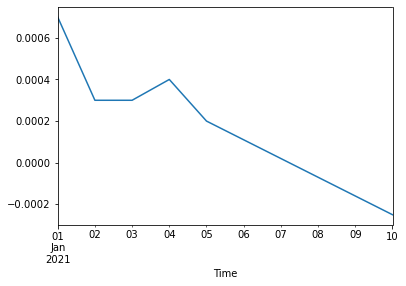

In [17]:
y.plot()

When doing time series analysis we always have to check for stationarity. Imprecisely, a time series dataset is stationary just if its statistical features don't change over time. A little more precisely, a stationary time series dataset will have constant mean, variance, and covariance.

There are many ways to test for stationarity, but one of the most common is the KPSS test. The Null hypothesis of this test is that the time series data in question is stationary; hence, if the p-value is less than the significance level (typically 0.05, but we decide) then we reject the Null and infer that the data is not stationary

In [21]:
from statsmodels.tsa.stattools import kpss
kpss(y,nlags='legacy')

(0.41374484315404353,
 0.0712306710542916,
 7,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Our p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary.

In [22]:
#preprocessing 
from sklearn.preprocessing import OneHotEncoder
traindfcat = x.select_dtypes(include ='object') 
enc = OneHotEncoder(sparse=False)
X_transfCat = enc.fit_transform(traindfcat)

### The ARIMA model

ARIMA models are based around the idea that it's possible to predict the next value in a time series by using information about the most recent data points. It also assumes there will be some randomness in our data that can't ever be predicted.

We can find some good parameters for our model using the sklearn and statsmodels libraries, and in particular mean_squared_error and ARIMA.

In [24]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

Make a function to find the MSE of a single ARIMA model¶

In [25]:
# Make a function called evaluate_arima_model to find the MSE of a single ARIMA model 
def evaluate_arima_model(data, arima_order):
    # Needs to be an integer because it is later used as an index.
    # Use int()
    split=int(len(data) * 0.8) 
    # Make train and test variables, with 'train, test'
    train, test = data[0:split], data[split:len(data)]
    past=[x for x in train]
    # make predictions
    predictions = list()
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARIMA model. 
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit(disp=0)
        future = model_fit.forecast()[0]
        predictions.append(future)
        past.append(test[i])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    # Return the error
    return error

Make a function to evaluate the different ARIMA models with different p, d, and q values

In [26]:
# Make a function called evaluate_models to evaluate different ARIMA models with several different p, d, and q values.
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    # Iterate through p_values
    for p in p_values:
        # Iterate through d_values
        for d in d_values:
            # Iterate through q_values
            for q in q_values:
                # p, d, q iterator variables in that order
                order = (p,d,q)
                try:
                    # Make a variable called mse for the Mean squared error
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    return print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [27]:
# Now, we choose a couple of values to try for each parameter: p_values, d_values and q_values
# Fill in the blanks as appropriate
p_values = [x for x in range(0, 3)]
d_values = [x for x in range(0, 3)]
q_values = [x for x in range(0, 3)]

In [29]:
# Finally, we can find the optimum ARIMA model for our data.
# Nb. this can take a while...!
import warnings
warnings.filterwarnings("ignore")
evaluate_models(y, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.000
ARIMA(0, 0, 1) MSE=0.000
ARIMA(0, 0, 2) MSE=0.000
ARIMA(0, 1, 0) MSE=0.000
ARIMA(0, 1, 1) MSE=0.000
ARIMA(0, 1, 2) MSE=0.000
ARIMA(0, 2, 0) MSE=0.000
ARIMA(0, 2, 1) MSE=0.000
ARIMA(1, 0, 0) MSE=0.000
ARIMA(1, 1, 0) MSE=0.000
ARIMA(1, 2, 0) MSE=0.000
ARIMA(2, 0, 0) MSE=0.000
ARIMA(2, 1, 0) MSE=0.000
ARIMA(2, 2, 0) MSE=0.000
Best ARIMA(0, 1, 1) MSE=0.000


In [30]:
p=0
d=1
q=1
model = ARIMA(y, order=(p,d,q))
model_fit = model.fit()
forecast = model_fit.forecast(24)

In [31]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.size4   No. Observations:                    9
Model:                 ARIMA(0, 1, 1)   Log Likelihood                  70.299
Method:                       css-mle   S.D. of innovations              0.000
Date:                Sun, 10 Jan 2021   AIC                           -134.599
Time:                        17:03:30   BIC                           -134.007
Sample:                    01-02-2021   HQIC                          -135.875
                         - 01-10-2021                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             -9e-05    9.5e-06     -9.474      0.000      -0.000   -7.14e-05
ma.L1.D.size4    -0.9979      0.286     -3.485      0.000      -1.559      -0.437
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0021           +0.0000j            1.0021            0.0000
-----------------------------------------------------------------------------
"""

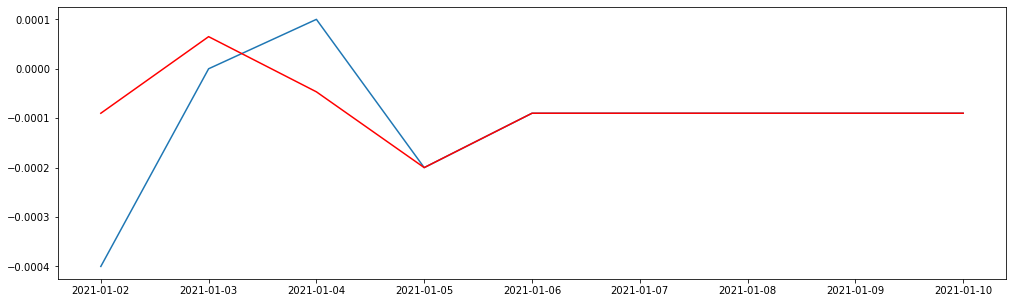

In [42]:
import matplotlib as plt

from matplotlib import *
import sys
import pylab as pl
pl.figure( figsize =(17,5) )
pl.plot(y.diff())
pl.plot(model_fit.predict(),color='red')

Model fits pretty closely to our actual data. 

#### Application: Forecasting

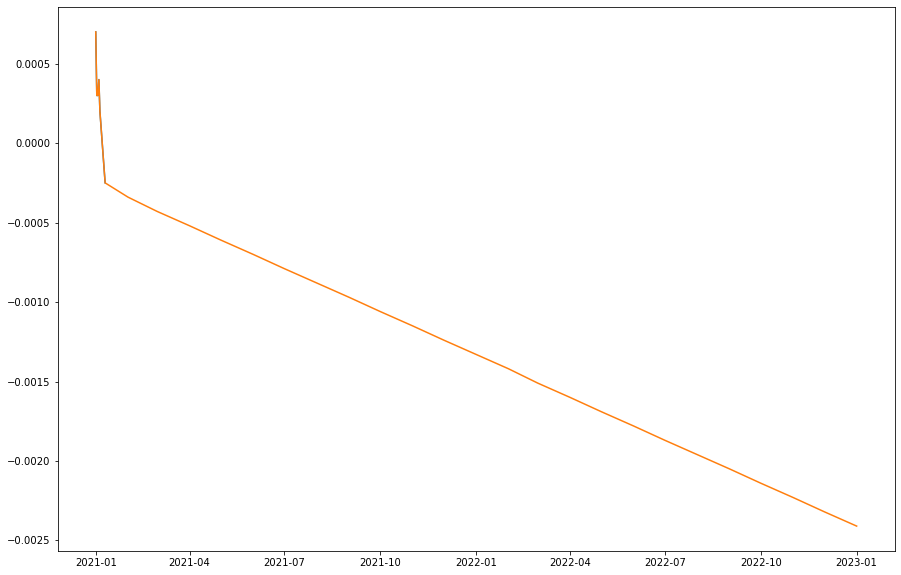

In [53]:
# Declare a variable called forecast_period with the amount of months to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast
from matplotlib import *
import sys
import pylab as pl
forecast_period = 24
date_range = pd.date_range(y.index[-1], periods = forecast_period, 
              freq='MS').strftime("%Y-%m-%d").tolist()

# Convert that range into a dataframe that includes your predictions

future_months = pd.DataFrame(date_range, columns = ['Month'])
future_months['Month'] = pd.to_datetime(future_months['Month'])
future_months.set_index('Month', inplace = True)
future_months['Prediction'] = forecast[0]

# Plot your future predictions
pl.figure(figsize=(15,10))
pl.plot(y)
pl.plot(y['2021'].append(future_months['Prediction']))
pl.show()

### Evaluating and Concluding